In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from astropy.io import fits
pandarallel.initialize(progress_bar=True)
import random
from numpy.random import default_rng
import numpy as np
rng = default_rng(42)
import shutil
import glob
from scipy import ndimage
import glob



INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [63]:
path_data = "/home/nicolas/nico/Data/SAD_CNN"

In [64]:
import glob
import os

# Path to the directory with a wildcard to fetch all files
path = '/home/nicolas/nico/Data/SAD_CNN/z_cero/fits_detected/*'
# Retrieve full paths of all files
file_paths = glob.glob(path)
# Extract only the filenames
file_names = [os.path.basename(file) for file in file_paths]



In [65]:
df = pd.DataFrame({"AU":file_names})

In [66]:
df["label"]= 1 

In [67]:
import glob
import os

# Path to the directory with a wildcard to fetch all files
path = '/home/nicolas/nico/Data/SAD_CNN/z_cero/fits_undetected/*'
# Retrieve full paths of all files
file_paths = glob.glob(path)
# Extract only the filenames
file_names_undetected = [os.path.basename(file) for file in file_paths]

In [68]:
df_dos = pd.DataFrame({"AU":file_names_undetected})

In [69]:
df_dos["label"] = 0 

In [70]:
df = pd.concat([df,df_dos])

In [71]:
df["brillo"] = df["AU"].str.split("_").str[2].str[2:]

In [72]:
df["brillo"] = df["brillo"].astype(float)

In [76]:
df["AU"] = df["AU"].str[:-5]

In [77]:
df_final = df 

In [78]:
df_final.loc[df_final.sample(frac=0.1,weights='brillo',random_state=2).index,"subgrup"] = "test"
mask1 = df_final.loc[df_final["subgrup"]!="test"].sample(frac=0.21,weights='brillo',random_state=42).index
df_final.loc[mask1,"subgrup"] = "val"
df_final.loc[df_final["subgrup"].isna(),"subgrup"] = "train"


/tmp/ipykernel_5052/2041415555.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


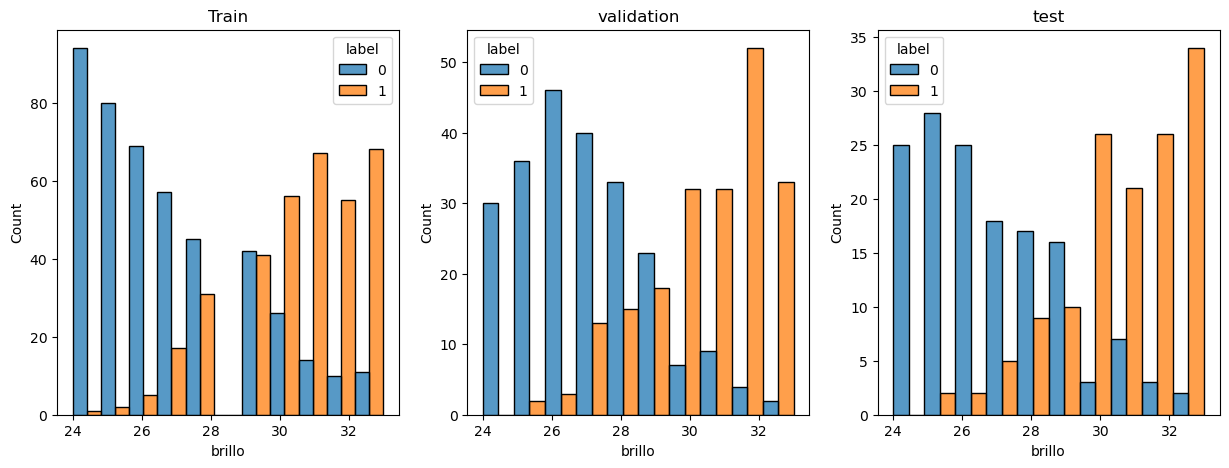

In [79]:
fig,ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=ax[0],data=df_final.loc[df_final["subgrup"]=="train"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[1],data=df_final.loc[df_final["subgrup"]=="val"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[2],data=df_final.loc[df_final["subgrup"]=="test"],x="brillo",hue="label", multiple="dodge")
ax[0].set_title('Train')
ax[1].set_title('validation')
ax[2].set_title('test')
fig.show()

In [80]:
def abrir_fits(ruta):
    hdu_list = fits.open(ruta,memmap=False)
    image_data = hdu_list[0].data
    hdu_list.close()
    return image_data

In [81]:
def data_augmentation(path_plots,nomb,img,rng,tipo,numero):
    '''
    Función que genera una imagen fits con rotación al azar entre 0 y 360
    El rng permite que no se repitan las rotaciones
    hay un choice para seleccionar flip en el eje x, y o ambos
    '''

    angulo_de_rotacion = rng.choice(360, size=1, replace=False)[0]
    img_rotate = ndimage.rotate(img,angulo_de_rotacion, reshape=False,mode='reflect')
    flip_x = np.fliplr(img_rotate)
    flip_y = np.flipud(img_rotate)
    flip_xy = np.flipud(np.fliplr(img_rotate))
    mylist = [flip_x,flip_y,flip_xy]
    random_image = random.choice(mylist)
    plt.imshow(random_image, cmap=plt.cm.brg)
    hdu = fits.PrimaryHDU(random_image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(f'{path_plots}{tipo}/{numero}_{nomb}.fits',overwrite=True)
    return

In [82]:
train = df_final.loc[df_final["subgrup"]=="train"].reset_index(drop=True)
val = df_final.loc[df_final["subgrup"]=="val"].reset_index(drop=True)
test = df_final.loc[df_final["subgrup"]=="test"].reset_index(drop=True)

In [83]:
train.to_csv("labels/z_cero/train.csv",index=False)
val.to_csv("labels/z_cero/val.csv",index=False)
test.to_csv("labels/z_cero/test.csv",index=False)

In [84]:
train["image"] = train.parallel_apply(lambda row : abrir_fits(f"{path_data}/z_cero/all_fits/"+ row["AU"]+".fits"), axis=1)


In [85]:
numero_training = train.groupby(["brillo","label"]).count()["AU"].max()

In [86]:
%mkdir $path_data/z_cero/all_fits/data_augmentation/

In [87]:
%mkdir $path_data/z_cero/all_fits/data_augmentation/0

In [88]:
%mkdir $path_data/z_cero/all_fits/data_augmentation/1

In [91]:
training_df = train.loc[train["label"]==1].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])
for tipos in training_df["brillo"].unique() :
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/z_cero/all_fits/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path_data}/z_cero/all_fits/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/z_cero/all_fits/data_augmentation/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")

In [92]:
training_df = train.loc[train["label"]==0].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])
for tipos in training_df["brillo"].unique() :
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/z_cero/all_fits/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path_data}/z_cero/all_fits/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/z_cero/all_fits/data_augmentation/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")

In [93]:
train.loc[train["label"]==0].parallel_apply(lambda row : shutil.copy(f"{path_data}/z_cero/all_fits/" + row["AU"] +".fits",f"{path_data}/z_cero/all_fits/data_augmentation/0/"),axis=1,result_type="expand")

343    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
344    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
345    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
346    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
347    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
                             ...                        
786    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
787    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
788    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
789    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
790    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
Length: 448, dtype: object

In [94]:
train.loc[train["label"]==1].parallel_apply(lambda row : shutil.copy(f"{path_data}/z_cero/all_fits/" + row["AU"] +".fits",f"{path_data}/z_cero/all_fits/data_augmentation/1/"),axis=1,result_type="expand")

0      /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
1      /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
2      /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
3      /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
4      /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
                             ...                        
338    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
339    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
340    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
341    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
342    /home/nicolas/nico/Data/SAD_CNN/z_cero/all_fit...
Length: 343, dtype: object

In [95]:
%ls $path_data/z_cero/all_fits/data_augmentation/0 | wc

    940     940   28000


In [96]:
%ls $path_data/z_cero/all_fits/data_augmentation/1 | wc

    940     940   28334
